# Nonrenewable Resource Management (Splineの場合)

## 設定

* 鉱山経営者が利潤を最大化する鉱石の掘り出し方を考えたい。

* 毎期sの鉱石残量が与えられ、xだけ採掘する。

* 各期の採掘コストはc(s,x)で　$$c_{s} \leq 0$$  $$c_{x} \geq 0$$  $$c_{s}(s,0)=0$$

* 各期の鉱石の市場価格はp(x)で　$$p' \leq 0$$

* 鉱石の初期賦存量に$\bar{s}$が与えられるとする。

##### state variable

$$s∈[{0,\bar{s}}]$$

##### action variable 

$$x∈[{0,s}]$$

##### transition function

$$g(s,x)=s-x$$

##### reward function

$$f(s,x) = p(x) x-c(s,x)$$

##### Bellman equation

$$V(s)=\max_ {0\leq x \leq s}  {p(x) x-c(s,x)+\delta V(s-x)}$$


In [1]:
using QuantEcon
using BasisMatrices
using Optim 
using Plots

* structでパラメーターの情報を格納

In [2]:
struct NonrenewableResource
    a1::Float64 # inverse demand function parameter
    a2::Float64 # inverse demand function parameter
    b1::Float64 # cost function parameter
    b2::Float64 # cost function parameter
    delta::Float64 # Discount factor
    s_vec::Vector{Float64} # ore grid
end

* 基底関数とノードの数、stateの上限と下限、を指定してfspaceにどのような補間をするかの情報を格納
* 3次のスプライン補間を行う

In [3]:
n = 100
smin = 0
smax = 10
fspace = Basis(SplineParams(n-2,smin,smax,3))
snodes = nodes(fspace)

([0.0, 0.0343643, 0.103093, 0.206186, 0.309278, 0.412371, 0.515464, 0.618557, 0.721649, 0.824742  …  9.17526, 9.27835, 9.38144, 9.48454, 9.58763, 9.69072, 9.79381, 9.89691, 9.96564, 10.0], Array{Float64,1}[[0.0, 0.0343643, 0.103093, 0.206186, 0.309278, 0.412371, 0.515464, 0.618557, 0.721649, 0.824742  …  9.17526, 9.27835, 9.38144, 9.48454, 9.58763, 9.69072, 9.79381, 9.89691, 9.96564, 10.0]])

In [4]:
NR = NonrenewableResource(10,0.8,12,1.0,0.9,snodes[1])

NonrenewableResource(10.0, 0.8, 12.0, 1.0, 0.9, [0.0, 0.0343643, 0.103093, 0.206186, 0.309278, 0.412371, 0.515464, 0.618557, 0.721649, 0.824742  …  9.17526, 9.27835, 9.38144, 9.48454, 9.58763, 9.69072, 9.79381, 9.89691, 9.96564, 10.0])

In [5]:
function update_Bellman(NR::NonrenewableResource,V::Vector)
    
    a1,a2,b1,b2,delta = NR.a1,NR.a2,NR.b1,NR.b2,NR.delta
    V_new = similar(V)
    x_opt = similar(V)
    
    # 補間の準備.３次のスプラインで補間する
    fspace = Basis(SplineParams(n,smin,smax,3))
    s_vec,_ = nodes(fspace)
    Φ = BasisMatrix(fspace, Expanded(), s_vec, 0)
    coeffs_V = Φ.vals[1] \ s_vec
    
    for (s_idx,s) in enumerate(NR.s_vec)
        objective(x) = -((a1-a2*x)*x-(b1*x-0.5*b2*x*(2s-x))+delta*(funeval(coeffs_V,fspace,s-x)))
        opt = optimize(objective, 0, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
        
    end
    
    return V_new,x_opt
    
end
#objective(x) = -((a1-a2*x)*x-(b1*x-0.5*b2*x*(2s-x))+delta*V_func.(s-x))

update_Bellman (generic function with 1 method)

* Initial guessを与えて、ベルマン方程式を更新していく

In [6]:
# Initial guess
V = zeros(length(NR.s_vec));

In [7]:
V_computed, x_opt = update_Bellman(NR,V)  

([0.0, 0.0309278, 0.0927835, 0.185567, 0.278351, 0.371134, 0.463918, 0.556701, 0.649485, 0.742268  …  15.8306, 16.1742, 16.522, 16.8738, 17.2297, 17.5897, 17.9538, 18.322, 18.5697, 18.6942], [0.0, 3.31207e-16, 3.91815e-16, 2.62265e-16, 2.26935e-16, 3.6998e-16, 2.4043e-16, 3.32925e-16, 4.00155e-16, 2.35276e-16  …  2.41356, 2.45321, 2.49286, 2.53251, 2.57216, 2.61182, 2.65147, 2.69112, 2.71755, 2.73077])

In [8]:
n = 300
V_computed = similar(V)
x_opt = similar(V)
resid = Vector{Float64}(n)

for i in 1:n
    V_computed, x_opt = update_Bellman(NR,V)       

    #for j in 1:length(V_computed)
     #  resid[j] =  V_computed[j] - funeval(coeffs_V,fspace,snodes[1][j])
    #end
    
    copy!(V, V_computed)
    
end

In [9]:
V

100-element Array{Float64,1}:
  0.0      
  0.0309278
  0.0927835
  0.185567 
  0.278351 
  0.371134 
  0.463918 
  0.556701 
  0.649485 
  0.742268 
  0.835052 
  0.927835 
  1.02062  
  ⋮        
 15.1556   
 15.491    
 15.8306   
 16.1742   
 16.522    
 16.8738   
 17.2297   
 17.5897   
 17.9538   
 18.322    
 18.5697   
 18.6942   

In [10]:
x_opt

100-element Array{Float64,1}:
 0.0        
 3.31207e-16
 3.91815e-16
 2.62265e-16
 2.26935e-16
 3.6998e-16 
 2.4043e-16 
 3.32925e-16
 4.00155e-16
 2.35276e-16
 2.92441e-16
 3.49606e-16
 3.88629e-16
 ⋮          
 2.33426    
 2.37391    
 2.41356    
 2.45321    
 2.49286    
 2.53251    
 2.57216    
 2.61182    
 2.65147    
 2.69112    
 2.71755    
 2.73077    


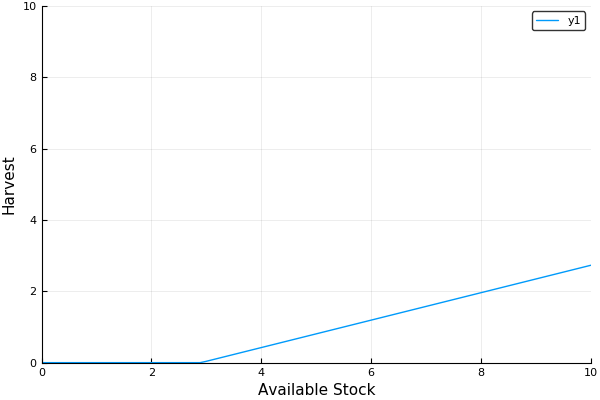

In [11]:
plot(NR.s_vec,x_opt,xlabel="Available Stock",ylabel="Harvest",xlim=(0,10),ylim=(0,10))
#s = 3(?)の時点で生産が止まっている


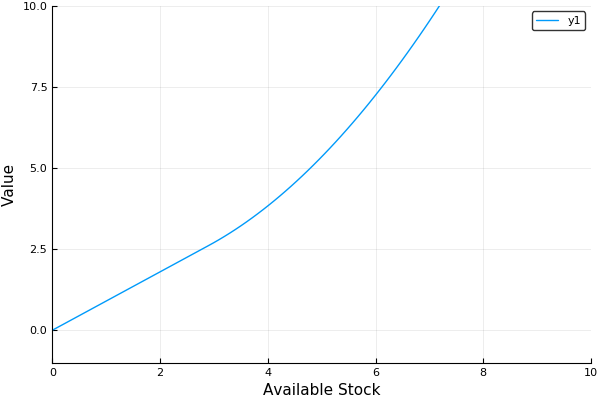

In [12]:
plot(NR.s_vec,V,xlabel="Available Stock",ylabel="Value",xlim=(0,10),ylim=(-1,10))
#s = 3でValueが0にならない


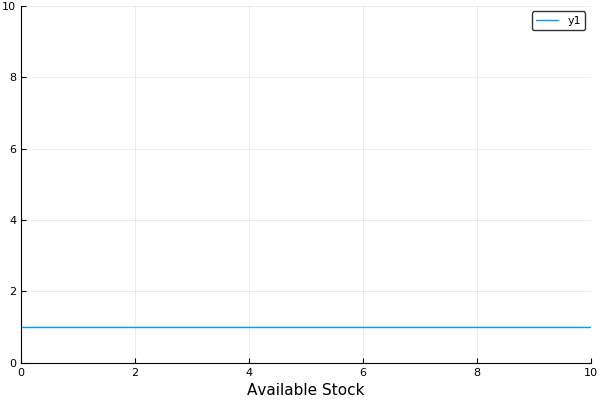

In [13]:
Φ = BasisMatrix(fspace, Expanded(), NR.s_vec, 0)
coeffs_V = Φ.vals[1] \ NR.s_vec
order = 1
B1 = evalbase(fspace.params[1], NR.s_vec, order)
interp1 = B1 * coeffs_V
plot(NR.s_vec, interp1,xlabel="Available Stock", xlim = (0,10),ylim=(0,10))
#微分して1  ====>    y=x+cという形状で補間されている....?

In [14]:
plot(NR.s_vec,funeval(coeffs_V,fspace,s_vec),xlabel="Available Stock",ylabel="funeval")
#補完する関数がsの1次関数になってしまっている

LoadError: [91mUndefVarError: s_vec not defined[39m

In [15]:
resid1 = V - funeval(coeffs_V,fspace,s_vec,xlabel="Available Stock",ylabel="funeval")
plot(s_vec,resid)

LoadError: [91mfunction funeval does not accept keyword arguments[39m